In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error
import sklearn.preprocessing

from src.mlhgp import MLHGP

In [2]:
def f1(X, add_noise=False):
    target = X * np.sin(X) + np.sqrt(16*X)
    if add_noise:
        rng = np.random.RandomState(1)
        target += rng.normal(0, 1, size=target.shape)
    return target.squeeze()

f2 = np.cos
transform = np.exp

# Test Data

In [3]:
X = np.linspace(start=0, stop=10, num=1000).reshape(-1, 1)

# Compute loc and scale as functions of input X
loc = f1(X, add_noise=False).reshape(-1,1)
scale = transform(f2(X))

# Sample outputs Y from Gaussian Likelihood
Y = np.random.normal(loc, scale)

# Training Data

In [4]:
rng = np.random.RandomState(0)
X_train = rng.uniform(0, 10, size=20).reshape(-1, 1)
mean_train = f1(X_train, add_noise=False).reshape(-1,1)
scale_train = transform(f2(X_train))

np.random.seed(17)
y_train = np.random.normal(mean_train, scale_train)

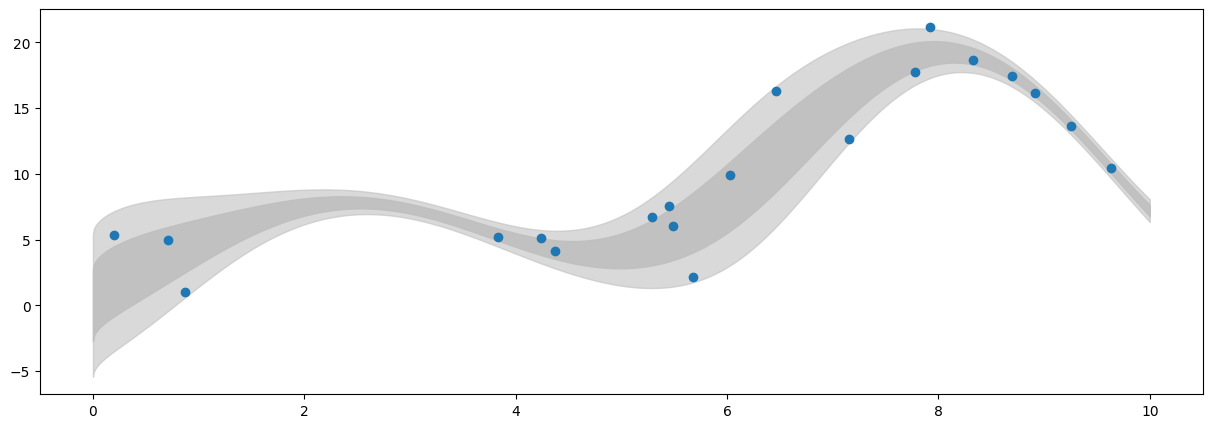

In [5]:
plt.figure(figsize=(15, 5))
x = X.squeeze()
for k in (1, 2):
    lb = (loc - k * scale).squeeze()
    ub = (loc + k * scale).squeeze()
    plt.fill_between(x, lb, ub, color="silver", alpha=1 - 0.05 * k ** 3)
plt.scatter(X_train, y_train)

# Most Likely Heteroscedastic Gaussian Process approach

In [17]:
# Normalize X
normalizer = sklearn.preprocessing.StandardScaler().fit(X_train)
X_train_norm = normalizer.transform(X_train)
X_norm = normalizer.transform(X)

# define the model
kernel = ConstantKernel(1.0) * RBF(length_scale=1e-1, length_scale_bounds=(1e-3, 1)) + WhiteKernel(
noise_level=1, noise_level_bounds=(1e-3, 1e2)
)
kernel_noise = ConstantKernel(1.0) * RBF(length_scale=1e-1, length_scale_bounds=(1e-3, 1)) + WhiteKernel(
    noise_level=1, noise_level_bounds=(1e-3, 1e2)
)

model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=25)
model_noise = GaussianProcessRegressor(kernel=kernel_noise, n_restarts_optimizer=25)

hgp = MLHGP(model, model_noise, max_iter=10)

# fit the model
hgp.fit(X_train_norm, y_train.flatten(), print_noise_rmse=False)

# make a prediction 
Y_pred, Std_pred = hgp.predict(X_norm, return_std="multi")

std_al, std_ep = Std_pred
std_tot = np.sqrt(std_al**2 + std_ep**2)

/Users/fazaghifari/miniconda3/envs/raenv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/fazaghifari/miniconda3/envs/raenv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/fazaghifari/miniconda3/envs/raenv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/

In [18]:
hgp.model.kernel_

9.29**2 * RBF(length_scale=0.728) + WhiteKernel(noise_level=0.001)

In [19]:
hgp.model_noise.kernel_

1.68**2 * RBF(length_scale=0.473) + WhiteKernel(noise_level=0.193)

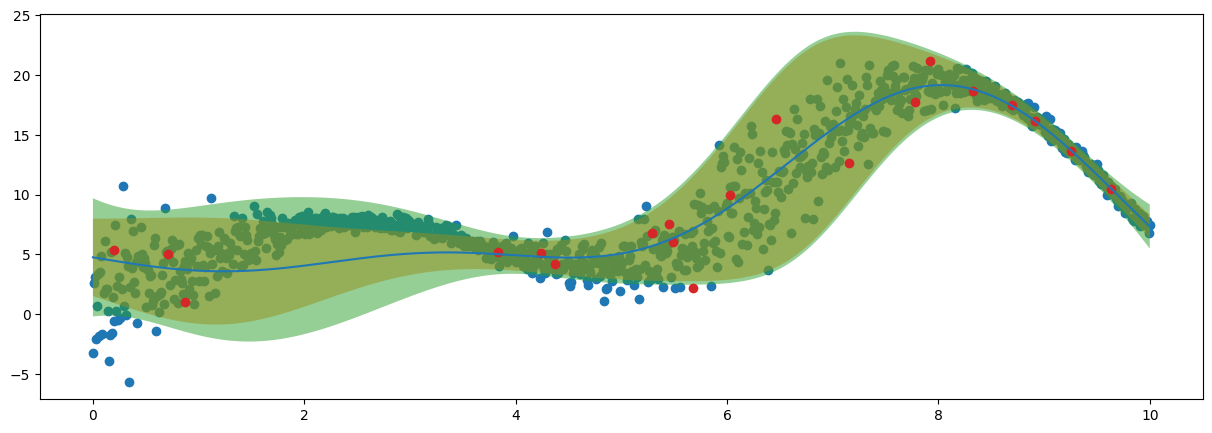

In [20]:
plt.figure(figsize=(15, 5))
plt.scatter(X,Y)
x = X.squeeze()
plt.fill_between(
    X.ravel(),
    Y_pred - 1.96 * (std_al),
    Y_pred + 1.96 * (std_al),
    alpha=0.5,
    label=r"Observed data stdev",
)
plt.fill_between(
    X.ravel(),
    Y_pred - 1.96 * std_tot,
    Y_pred + 1.96 * std_tot,
    alpha=0.5,
    label=r"Prediction uncertainty",
)
plt.plot(X, Y_pred)
plt.scatter(X_train, y_train)

In [10]:
np.sqrt(hgp.variance_est)

array([1.86705504, 3.0007243 , 1.87352067, 1.95929167, 1.98754619,
       3.64909587, 1.89892602, 1.76236309, 2.03216915, 2.12181104,
       2.67683884, 1.90917863, 4.16271953, 1.8101518 , 2.23128394,
       2.75010681, 2.35921579, 1.80305912, 1.83219714, 1.78230309])

In [11]:
hgp.model_noise.predict(X_train)

array([1.02092447, 0.8256007 , 0.95721345, 1.02556232, 1.16706175,
       0.90640887, 1.15103482, 0.62918371, 0.55503454, 1.21280131,
       0.73838445, 1.04441255, 0.99821719, 0.59380051, 1.52169018,
       1.50855804, 1.56063606, 0.69299509, 0.75364698, 0.65238529])

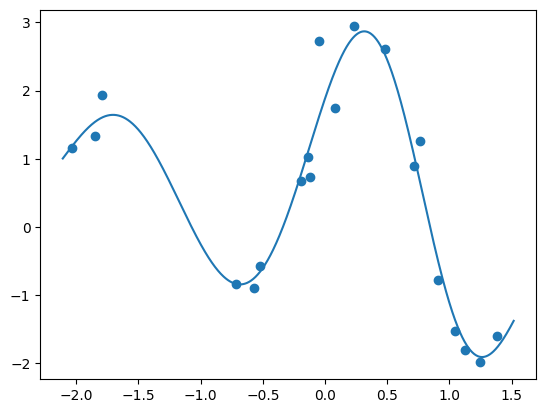

In [26]:
sorted_xtrain = np.sort(X_train_norm, axis=0)
plt.scatter(X_train_norm,np.log(hgp.variance_est))
plt.plot(X_norm, (hgp.model_noise.predict(X_norm)))

In [29]:
hgp.model.kernel_

9.29**2 * RBF(length_scale=0.728) + WhiteKernel(noise_level=0.001)

In [32]:
from scipy.spatial.distance import cdist, pdist, squareform

In [54]:
lenscale = np.exp(hgp.model.kernel_.theta[1:-1])

In [66]:
dist = cdist(X_norm / lenscale, X_train_norm / lenscale, metric="sqeuclidean")
dists = np.exp(-0.5 * dist)
weights = (dists.T/dists.sum(axis=1)).T

In [68]:
np.argmax(weights[0,:])

16

In [69]:
weights[0,:]

array([7.22399926e-03, 5.34969678e-04, 3.34824077e-03, 7.61876119e-03,
       3.25863351e-02, 1.71917722e-03, 2.80889105e-02, 1.59581469e-05,
       3.06176746e-06, 4.86967642e-02, 1.28341591e-04, 9.42255651e-03,
       5.53761142e-03, 7.45684480e-06, 2.82298854e-01, 2.73543599e-01,
       2.98976294e-01, 5.64017954e-05, 1.67057943e-04, 2.56486805e-05])

In [74]:
dists

array([[2.40405032e-02, 1.78030753e-03, 1.11424974e-02, ...,
        1.87697630e-04, 5.55946488e-04, 8.53553780e-05],
       [2.43693688e-02, 1.81211696e-03, 1.13100326e-02, ...,
        1.91608039e-04, 5.66763427e-04, 8.72144061e-05],
       [2.47021204e-02, 1.84444900e-03, 1.14798020e-02, ...,
        1.95595064e-04, 5.77776498e-04, 8.91117133e-05],
       ...,
       [8.23036641e-02, 3.71595133e-01, 1.44645005e-01, ...,
        7.12824500e-01, 5.49800349e-01, 8.16485710e-01],
       [8.13916475e-02, 3.68995574e-01, 1.43233530e-01, ...,
        7.09900527e-01, 5.46806642e-01, 8.13890294e-01],
       [8.04877406e-02, 3.66405113e-01, 1.41832311e-01, ...,
        7.06971011e-01, 5.43815746e-01, 8.11283004e-01]])

In [79]:
X_train_norm[16]

array([-2.03445257])

In [80]:
X_norm[0]

array([-2.10773014])

In [81]:
smoothed_y = weights @ np.log(hgp.variance_est)

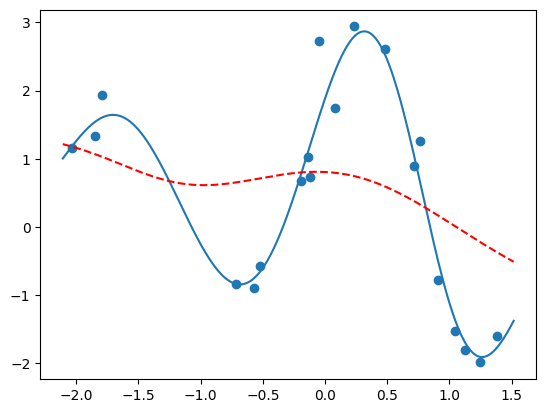

In [82]:
sorted_xtrain = np.sort(X_train_norm, axis=0)
plt.scatter(X_train_norm,np.log(hgp.variance_est))
plt.plot(X_norm, (hgp.model_noise.predict(X_norm)))
plt.plot(X_norm, smoothed_y, '--r')

In [13]:
np.sort(X_train, axis=0)

array([[0.20218397],
       [0.71036058],
       [0.871293  ],
       [3.83441519],
       [4.23654799],
       [4.37587211],
       [5.2889492 ],
       [5.44883183],
       [5.48813504],
       [5.68044561],
       [6.02763376],
       [6.45894113],
       [7.15189366],
       [7.78156751],
       [7.91725038],
       [8.32619846],
       [8.70012148],
       [8.91773001],
       [9.25596638],
       [9.63662761]])